### John Bredall

In this assignment, we plan to calculate the distance to M45 (the Pleiades Cluster) based on parallax data from HIPPARCOS. In order to get an accurate distance, we will need to determine which stars are actually part of the cluster, and which stars are in the foreground and background.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Grabs the data from the file and saves it into a dictionary
data = np.genfromtxt("Data/pleiades.dat", skip_header=4,
                     usecols=(11,12,13,14,19,20,23,24,9,10,), delimiter='')

stars = {'pmRA':data[:,0], 'e_pmRA':data[:,1], 'pmDE':data[:,2],
         'e_pmDE':data[:,3], 'Hpmag':data[:,4], 'e_Hpmag':data[:,5],
         'B-V':data[:,6], 'e_B-V':data[:,7], 'Plx':data[:,8],
         'e_Plx':data[:,9]}


# Save the minimum and maximum parallax values for a consistent colorbar axis
Plx_minmax = [np.min(stars['Plx']), np.max(stars['Plx'])]


# Function for plotting the color-mag diagram
def color_mag(title):
    plt.figure(figsize=(8,8))

    # Plot the data
    cax = plt.scatter(stars['B-V'], stars['Hpmag'], c=stars['Plx'],
                      cmap='plasma')
    cbar = plt.colorbar(cax)

    # Invert the Y-Axis
    ax = plt.gca()
    ax.set_ylim(ax.get_ylim()[::-1])
    
    # Define the minimum and maximum parallax:
    plt.clim(Plx_minmax[0], Plx_minmax[1])

    # Labelling
    plt.title(title, fontsize=15)
    plt.xlabel('B-V', fontsize=15)
    plt.ylabel('Hipparcos Magnitude', fontsize=15)
    cbar.set_label("Parallax", fontsize=15)

    plt.show()


# Function for plotting a histogram of the parallaxes
def histogram(title, bins=50):
    plt.figure(figsize=(8,8))

    # Create a histogram and define bar width and center value
    hist, bins = np.histogram(stars['Plx'], bins=bins)
    width = 0.7 * (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2

    # Plot the histogram
    plt.bar(center, hist, align='center', width=width)

    # Labelling
    plt.title(title, fontsize=15)
    plt.xlabel("Parallax", fontsize=15)
    plt.ylabel("Counts", fontsize=15)

    plt.show()


# Function for applying an n-sigma clipping to a given list. Returns an array
# of boolean values corresponding to entries that fit the criteria.
def sigma_clip(values, mean, stdev, n=1):
    
    good_values = []
    
    for i in values:
        if (i > mean - n * stdev and
            i < mean + n * stdev):

            good_values.append(True)
    
        else:
            good_values.append(False)
    
    return good_values

We will perform a series of tests. First, let us plot a color-mag diagram of the full list of stars.

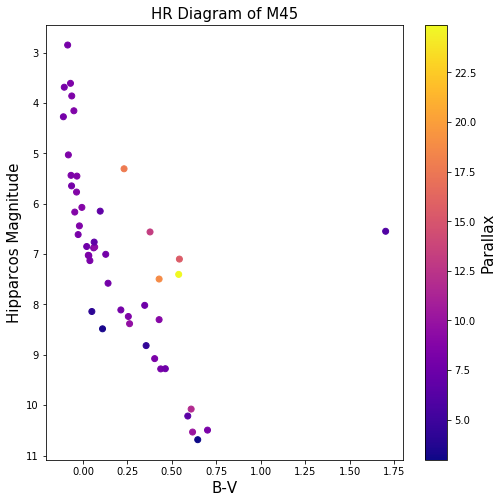

In [2]:
color_mag('HR Diagram of M45')

As we can see, there are stars that don't fall on the main sequence, as well as stars with rather varying parallax values. First, let us investigate the parallaxes of these stars and apply a simple sigma clipping. We start by plotting a histogram of the parallaxes of the stars.

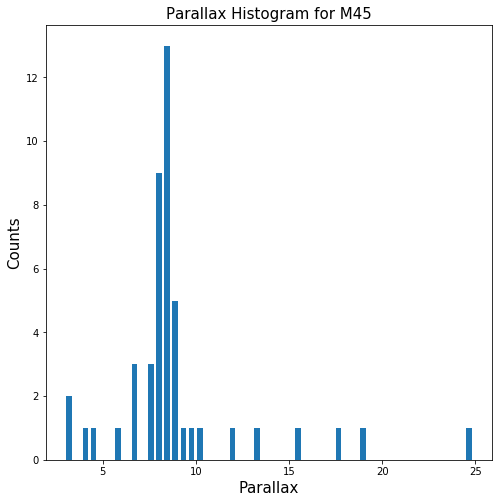

In [3]:
histogram('Parallax Histogram for M45')

Let's slice our array of stars using a 2-sigma clipping of the parallaxes. First, we find the mean and stdev:

In [4]:
Plx_mean = np.mean(stars['Plx'])
Plx_stdev = np.std(stars['Plx'])

print(f"Parallax Mean: {Plx_mean:.2f}\nParallax Stdev: {Plx_stdev:.2f}\n")

Parallax Mean: 8.97
Parallax Stdev: 3.72



Next we generate our boolean array of stars to keep using our function sigma_clip(), and slice our collection of stars based on this criteria.

In [5]:
good_stars = sigma_clip(stars['Plx'], Plx_mean, Plx_stdev, n=2)

for i in stars:
    stars[i] = stars[i][good_stars]

Now let's look at the new histogram and Color-Mag diagram:

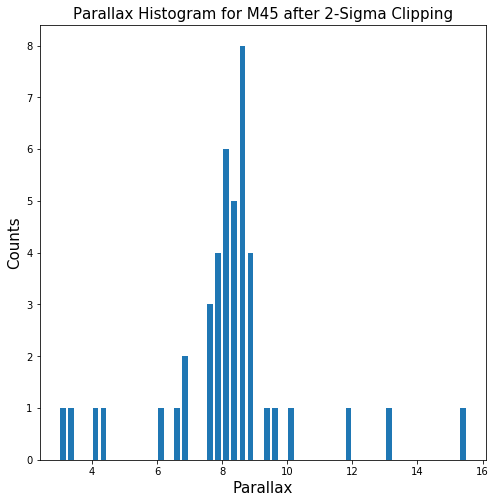

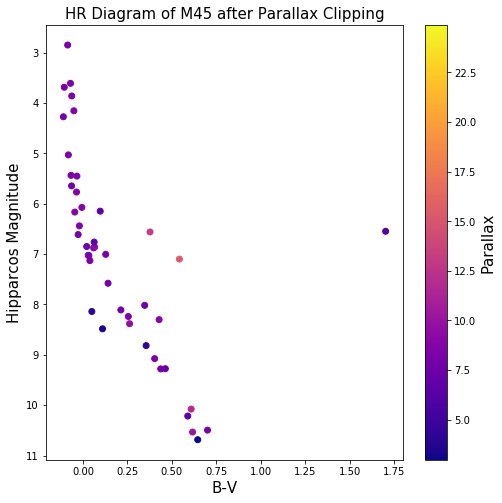

In [6]:
histogram('Parallax Histogram for M45 after 2-Sigma Clipping')
color_mag('HR Diagram of M45 after Parallax Clipping')

Let us now remove stars based on their Proper motions using the same process as before

In [7]:
pmRA_mean = np.mean(stars['pmRA'])
pmRA_stdev = np.std(stars['pmRA'])

pmDE_mean = np.mean(stars['pmDE'])
pmDE_stdev = np.std(stars['pmDE'])

print(f"RA Proper Motion Mean: {pmRA_mean:.2f}\n"
      f"RA Proper Motion Stdev: {pmRA_stdev:.2f}\n")
print(f"DEC Proper Motion Mean: {pmDE_mean:.2f}\n"
      f"DEC Proper Motion Stdev: {pmDE_stdev:.2f}\n")

RA Proper Motion Mean: 16.93
RA Proper Motion Stdev: 12.49

DEC Proper Motion Mean: -41.45
DEC Proper Motion Stdev: 10.79



First we slice the array based on the RA Proper Motion

In [8]:
good_stars = sigma_clip(stars['pmRA'], pmRA_mean, pmRA_stdev, n=2)

for i in stars:
    stars[i] = stars[i][good_stars]

Next we slice based on DEC Proper Motion

In [9]:
good_stars = sigma_clip(stars['pmDE'], pmDE_mean, pmDE_stdev, n=2)

for i in stars:
    stars[i] = stars[i][good_stars]

And plot the remaining stars:

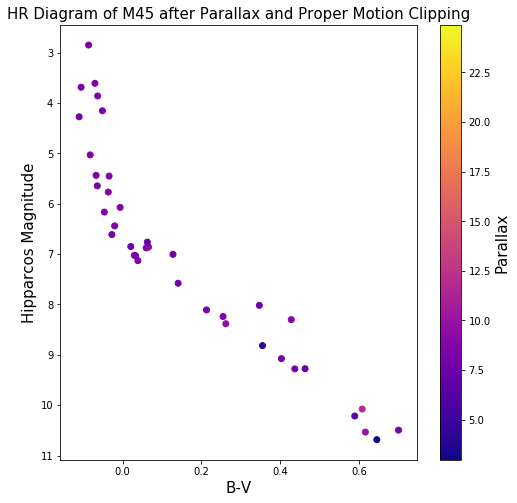

In [10]:
color_mag('HR Diagram of M45 after Parallax and Proper Motion Clipping')

Now we can compute the median parallax of our stars (We use median due to the small sample size) and thus distance to the cluster

In [11]:
Plx_median = np.median(stars['Plx'])
Plx_err = np.std(stars['Plx'])
M45_d = 1 / (Plx_median) * 1000
M45_d_err = Plx_err / Plx_median * M45_d

print(f"Median Parallax of M45: {Plx_median:.2f} +/- {Plx_err:.2f} mAS\n"
      f"Distance to M45: {M45_d:.2f} +/- {M45_d_err:.2f} pc")

Median Parallax of M45: 8.31 +/- 1.37 mAS
Distance to M45: 120.34 +/- 19.82 pc


And here we find the distance modulus $m - M = 5\log{\left(\frac{d}{10}\right)}$

In [12]:
dist_mod = 5 * np.log10(M45_d / 10)
dist_mod_err = 5 / np.log(10) * 1 / M45_d * M45_d_err

print(f"Distance Modulus of M45: {dist_mod:.2f} +/- {dist_mod_err:.2f}")

Distance Modulus of M45: 5.40 +/- 0.36
